# Exploring Practical Recommendation Systems In Neo4j
### __An Example With Collaborative Leveraging Graph Data Science and Machgine Learning__

In this notebook we explore how to get started with practical & scalable recommendation in graph. We will walk through a fundamental example with recipe recommendation on dataset containing 231k recipes and around 226K users. We will leverage Neo4j and the Graph Data Science (GDS) library to quickly predict similar recipes based on user preferences and enable sub-second, rank-ordered, recommendation queries personalized to each user.

This notebook is structured as follows: 

1. setup some configurations and helper functions to allow us to work with the graph. 
2. Go over the source dataset and graph we will be using along with how to query basic profiling statistics to help us understand the graph and better prepare for analysis. 
3. Briefly introduce a technique called Collaborative filtering (CF) which will be our mechanism for recommendation in this notebook
4. Explore Applying the Cypher query language for basic CF
5. Scaling CF with the Graph Data Science (GDS) Library, leveraging Node embeddings and an ML technique called K-Nearest Neighbor (KNN).

## Notebook Setup

In [1]:
from graphdatascience import GraphDataScience
import pandas as pd
import numpy as np
import configparser
import os
import time
import matplotlib.pyplot as plt
pd.set_option('display.width', 0)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 12)

### Neo4j Settings
The `NEO4J_PROPERTIES_FILE` is an ini configuration file for Neo4j properties so this notebook can connect to
your Neo4j instance and load data. The ini file should be formatted as follows
```
[NEO4J]
PASSWORD=<password>
USERNAME=<database name, is 'neo4j' by default>
HOST=<host uri>

```

Set `NEO4J_PROPERTIES_FILE` to None or any non-existent location to use the below defaults
```
HOST = 'neo4j://localhost'
USERNAME = 'neo4j'
PASSWORD = 'password'
```

In [2]:
NEO4J_PROPERTIES_FILE = None #'/path/to/your/file.ini'

In [3]:
# Using an ini file for credentials, otherwise providing defaults
HOST = 'bolt://localhost:7687'
DATABASE = 'neo4j'
PASSWORD = 'LU?vVtYf8])9;^z'

if NEO4J_PROPERTIES_FILE is not None and os.path.exists(NEO4J_PROPERTIES_FILE):
    config = configparser.RawConfigParser()
    config.read(NEO4J_PROPERTIES_FILE)
    HOST = config['NEO4J']['HOST']
    USERNAME = config['NEO4J']['USERNAME']
    PASSWORD = config['NEO4J']['PASSWORD']
    print('Using custom database properties')
else:
    print('Could not find database properties file, using defaults')

Could not find database properties file, using defaults


In [4]:
gds = GraphDataScience(HOST, auth=(DATABASE, PASSWORD))

### Helper Functions

In [5]:
class GraphQueryError(Exception):
    def __init__(self, message):
        self.message = message


def run(driver, query, params=None):
    with driver.session() as session:
        if params is not None:
            return [r for r in session.run(query, params)]
        else:
            return [r for r in session.run(query)]

def degree_counts(node_label, relationship_type, direction='BOTH'):
    dr = direction.upper()
    if dr not in {'BOTH', 'IN', 'OUT'}:
        raise GraphQueryError(f"direction must be one of {{'BOTH', 'IN', 'OUT'}}, but got {dr}")

    if dr == 'BOTH':
        pattern = f'[(n)-[:{relationship_type}]-() | n]'
    elif dr == 'OUT':
        pattern = f'[(n)-[:{relationship_type}]->() | n]'
    else:
        pattern = f'[(n)<-[:{relationship_type}]-() | n]'

    df= gds.run_cypher( f'''
            MATCH (n:{node_label}) WITH id(n) as nodeIds, size({pattern}) AS degree
            RETURN degree, count(degree) AS degreeCount ORDER BY degree
        ''')

    df['csum'] = df.degreeCount.cumsum()
    n = df.degreeCount.sum()
    df['percentile'] = df.csum/n
    return df.drop(columns=['csum'])

def get_percentiles(df, q=None):
    if q is None:
        q = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
    q_name = ['min'] + [f'p{int(100*i)}' for i in q] + ['max']
    p = [df.degree.min()] + [df.degree[df.percentile >= i].iloc[0] for i in q] + [df.degree.max()]
    p_df = pd.DataFrame(np.column_stack((q_name, p)), columns=['q', 'percentile'])
    return p_df.set_index('q')

```
//visualize schema in Neo4j Browser
neo4j$ CALL db.schema.visualization();
```
![image](./image/nodes.png)

We see that recipes are modeled as nodes and can can be "submitted" or "reviewed" by users which are also modeled as nodes. 
Additionally, News also have ingredients and it's relation with recipe. These will be useful for extended analysis, but we will not be using them in this example. Our primary interest here is to get started with users and their reviews to derive recommendations.

### Graph Data Profiling
Before diving right into into analysis, it is helpful to inspect some high level statistics of graph to get a better sense of size and connectivity.

#### Aggregate Counts
Let's start with high node and relationships counts. These functions assume [APOC](https://neo4j.com/developer/neo4j-apoc/) is installed on your Neo4j DB.

In [6]:
# total node counts
gds.run_cypher( '''
    CALL apoc.meta.stats()
    YIELD labels AS nodeCounts
    UNWIND keys(nodeCounts) AS label
    WITH label, nodeCounts[label] AS nodeCount
    WHERE label IN ['User','Recipe']
    RETURN label, nodeCount
''')

,label,nodeCount
0,User,226570
1,Recipe,231637


In [7]:
# total relationship counts
gds.run_cypher( '''
    CALL apoc.meta.stats()
    YIELD relTypesCount as relationshipCounts
    UNWIND keys(relationshipCounts) AS type
    WITH type, relationshipCounts[type] AS relationshipCount
    WHERE type IN ['REVIEWED','SUBMITTED']
    RETURN type, relationshipCount
''')

,type,relationshipCount
0,SUBMITTED,213598
1,REVIEWED,320000


As far as search recommendation is concerns this is a relatively modestly sized graph, with only around 226K users, 231k news articles, and around 500k total creations/reviews.

#### Reviews Distributions
Next, we can look at the distribution of events per user. It is helpful to check this distribution to make sure that:
1. The graph is reasonably well connected as the quality of our upcoming recommendation technique will depend on a reasonably well connected graph.
2. We do not have any large [supernodes](https://medium.com/neo4j/graph-modeling-all-about-super-nodes-d6ad7e11015b), i.e. nodes with very high numbers of relationships. What qualifies as a supernode varies greatly by use case. For this, I would be concerned about users with tens of thousands of clicks.

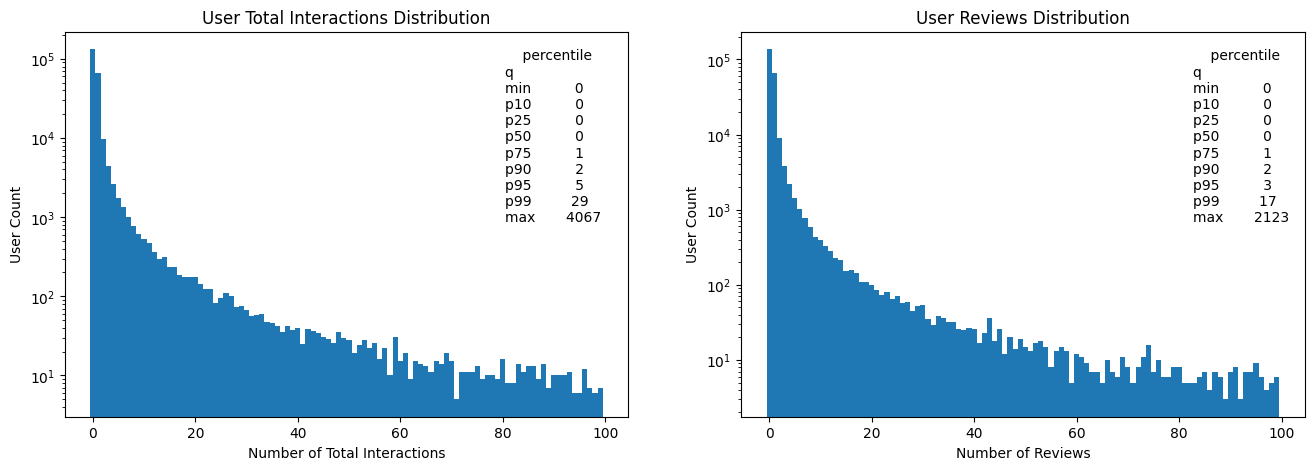

In [8]:
n_rew = 100

all_interactions_df = degree_counts( 'User', 'REVIEWED|SUBMITTED', 'OUT')
reviews_df = degree_counts('User', 'REVIEWED', 'OUT')

f, axs = plt.subplots(1,2,figsize=(16,5))

axs[0].bar(all_interactions_df.degree[:n_rew], all_interactions_df.degreeCount[:n_rew], width=1, log=True)
axs[0].set_title('User Total Interactions Distribution')
axs[0].set_ylabel('User Count')
axs[0].set_xlabel('Number of Total Interactions')
plt.figtext(0.4, 0.5, get_percentiles(all_interactions_df).to_string())

axs[1].bar(reviews_df.degree[:n_rew], reviews_df.degreeCount[:n_rew], width=1, log=True)
axs[1].set_title('User Reviews Distribution')
axs[1].set_ylabel('User Count')
axs[1].set_xlabel('Number of Reviews')
plt.figtext(0.83, 0.5, get_percentiles(reviews_df).to_string())

plt.show()

The above shows the distributions for total interactions (`REVIEWED` and `SUBMITTED`) as well as reviews (just `REVIEWED`) by user. We see that the distributions have heavy left tails, showing that activity is not uniformly distributed among users, but rather there is relatively small fraction of users that account for a large number of interactions. This is somewhat expected. 

We can do a similar breakdown for Recipe below.

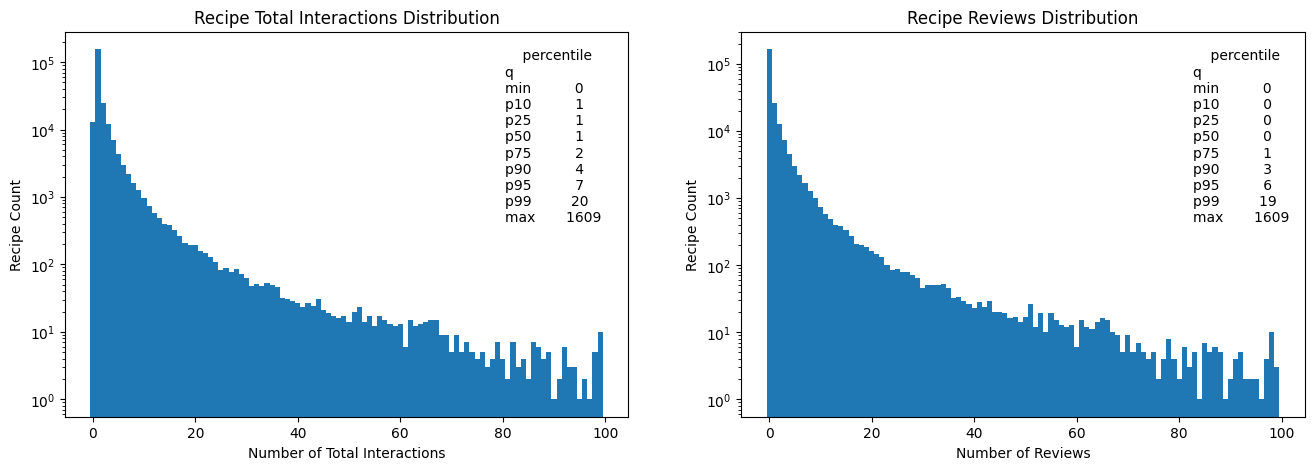

In [9]:
all_interactions_df = degree_counts('Recipe', 'REVIEWED|SUBMITTED', 'IN')
reviews_df = degree_counts('Recipe', 'REVIEWED', 'IN')
submit_df = degree_counts('Recipe', 'SUBMITTED', 'IN')

f, axs = plt.subplots(1,2,figsize=(16,5))

axs[0].bar(all_interactions_df.degree[:n_rew], all_interactions_df.degreeCount[:n_rew], width=1, log=True)
axs[0].set_title('Recipe Total Interactions Distribution')
axs[0].set_ylabel('Recipe Count')
axs[0].set_xlabel('Number of Total Interactions')
plt.figtext(0.4, 0.5, get_percentiles(all_interactions_df).to_string())


axs[1].bar(reviews_df.degree[:n_rew], reviews_df.degreeCount[:n_rew], width=1, log=True)
axs[1].set_title('Recipe Reviews Distribution')
axs[1].set_ylabel('Recipe Count')
axs[1].set_xlabel('Number of Reviews')
plt.figtext(0.83, 0.5, get_percentiles(reviews_df).to_string())

plt.show()

## Collaborative Filtering (CF)

There are many different types of recommendations systems. In this example we will apply a technique called Collaborative Filtering (CF), which is the practice of automatically predicting a user's preferences based on the actions of similar users.

### User vs Item Based CF
Roughly speaking there are two main classes of collaborative filtering
1. User-based, which is focuses on directly calculating similarity between users based on their interaction with items
2. Item-based, which measures the similarity between pairs of items based on correlated user activity, such as the same users liking, viewing, rating, or otherwise similarly interacting with items

Our approach today will focus on the later, item-based CF. Item-based CF will be more manageable and scalable then user-based CF for many problem domains. There are a couple reasons for this. First, because there are way fewer items then users in most applied cases so there are less entities to compare. Second, and perhaps more importantly, User preferences can also be dynamic and change overtime. For example, in a Movie example, a user could be mostly interested in Sci Fi movies but go through a brief stint in Westerns, and making recommendations for Westerns to other Sci Fi fans who historically viewed the same things may not be the best thing. Often the best indicator of a user's current interest is their most recent activity, and item based filtering gives you better flexibility to find similarities based off the most recent item(s) submitted, rated, etc.

## Basic Cypher Queries for CF
From here we could try just using Cypher to accomplish basic Collaborative Filtering. For example, take the below user and the news they clicked. You can see a mixed interest between autos, finance, US news, and a couple other categories.

In [10]:
# Select a random user that has at least n_reviews reviews
random_user_query = gds.run_cypher('''
    MATCH (u:User)-[:REVIEWED]->(:Recipe)
    WITH u, COUNT(*) AS reviewCount
    WHERE reviewCount >= $n_reviews
    WITH u, RAND() AS randomOrder, reviewCount
    ORDER BY randomOrder
    RETURN u.id AS randomUserID, reviewCount
    LIMIT 1
''', params={'n_reviews': 100})

USER_ID = str(random_user_query['randomUserID'][0])

print(f"Selected user {USER_ID} with", random_user_query['reviewCount'][0], 'reviews')

Selected user 552613 with 123 reviews


In [137]:
gds.run_cypher('''
    MATCH (u:User {id: $userId})-[i:SUBMITTED|REVIEWED]->(r:Recipe)
    RETURN r.id AS recipeID,
           r.name AS name,
           r.nutrition AS nutrition,
           r.n_ingredients AS n_ingredients,
           COALESCE(i.submitted, i.date) AS impressionTime,
           type(i) AS interactionType
    ORDER BY interactionType, impressionTime DESC
    ''', params={'userId': USER_ID})


,recipeID,name,nutrition,n_ingredients,impressionTime,interactionType
0,382156,splenda strawberry blueberry smoothie,"[300.9, 2.0, 209.0, 0.0, 9.0, 0.0, 24.0]",4,2010-07-31,REVIEWED
1,377832,vera s grasshopper adult,"[689.3, 40.0, 288.0, 8.0, 18.0, 81.0, 26.0]",3,2010-07-27,REVIEWED
2,411621,red velvet waffles,"[662.9, 24.0, 274.0, 30.0, 28.0, 44.0, 39.0]",10,2010-06-30,REVIEWED
3,345216,mango curry deviled eggs,"[58.7, 6.0, 2.0, 2.0, 6.0, 5.0, 0.0]",6,2010-06-27,REVIEWED
4,423394,toast hawaii open faced sandwich for a snack or dinner,"[383.1, 26.0, 69.0, 43.0, 37.0, 48.0, 13.0]",6,2010-06-23,REVIEWED
...,...,...,...,...,...,...
322,274747,chicken casserole supreme,"[276.3, 20.0, 4.0, 8.0, 16.0, 32.0, 10.0]",11,2007-12-29,SUBMITTED
323,273893,fruit loops non alcoholic cocktail,"[82.8, 0.0, 64.0, 0.0, 1.0, 0.0, 6.0]",4,2007-12-26,SUBMITTED
324,271421,really easy pork and sauerkraut bake,"[432.3, 32.0, 8.0, 33.0, 105.0, 36.0, 1.0]",4,2007-12-12,SUBMITTED
325,254976,light and tasty cucumber slices,"[25.7, 0.0, 6.0, 0.0, 1.0, 0.0, 1.0]",5,2007-09-24,SUBMITTED


Assuming we can measure the similarity of user interests via commonly reviewed recipes, we can do a three hop query to find potential recommendations for user `27711` based on the activity of users that reviewed the same recipe as `27711` (or even reviewed their recipe high).

With the below query we can get an aggregate count of the nodes we would need to traverse over to get the recommendations.

In [12]:
gds.run_cypher('''
       MATCH (u1:User {id: $userId})-[rw1:REVIEWED]->(r1:Recipe)
       WITH u1, COLLECT(r1) AS reviewedRecipes
       MATCH (u1)-[rw2:SUBMITTED]->(submitRecipe:Recipe)
       WITH u1, reviewedRecipes, COLLECT(submitRecipe) AS submitRecipes
       MATCH (u1)-[rw1]->(r1:Recipe)<-[rw2:REVIEWED]-(u2:User)-[r3:REVIEWED]->(r2:Recipe)
       WHERE NOT (r2 IN reviewedRecipes) AND NOT (r2 IN submitRecipes)
       RETURN u1.id AS userId,
              COUNT(DISTINCT r1) AS reviewedRecipesCount,
              COUNT(DISTINCT u2) AS likeUsersCount,
              COUNT(DISTINCT r2) AS potentialRecommendationsCount
    ''', params={'userId': USER_ID})

,userId,reviewedRecipesCount,likeUsersCount,potentialRecommendationsCount
0,552613,165,994,40446


While the above can work well in some cases, and while it can certainly be a massive improvement from joining SQL tables or cross-walking over document stores, notice that we get a lot of potential recommendations back (about 13K). And this is just a sample of the the total dataset.

For production use cases where recommendations will need to be queried frequently, this method will have trouble scaling as the number of users, amount of content, and/or observed engagement grows. We need some other strategy to help narrow down the results. There are a few different ways we can accomplish this, but one robust and scalable way to do so is with the [Neo4j Graph Data Science (GDS) Library](https://neo4j.com/docs/graph-data-science/current/).

### Recommendation based on favorite ingredients
First let's make a list of excluded ingredients. Those ingredients won't be considered as they're common ingredients in recipies.

In [13]:
# Define a list of (common) ingredients to exclude
excluded_ingr = [
    'butter', 'salt', 'sugar', 'all-purpose flour', 'baking powder', 'baking soda', 
    'olive oil', 'pepper', 'water', 'flour', 'eggs', 'egg'
]
# Define how many favorite ingredients we want to take into account
n_fav_ingr = 10
# Define how many recipe to suggest
n_sugestions = 5

In [14]:
start_time = time.time()

# Compute top 5 user ingredients
favIngr = gds.run_cypher('''
    MATCH (u:User {id: $userId})-[:REVIEWED {rating: 5}]->(r:Recipe)-[:WITH_INGREDIENTS]->(i:Ingredient)
    WHERE NOT i.name IN $excluded_ingr
    WITH i, COUNT(r) AS reviewCount, COLLECT(r.id) as reviewedRecipes
    ORDER BY reviewCount DESC
    LIMIT $limit
    RETURN i.name AS favoriteIngredient, reviewCount, reviewedRecipes
    ''', params={'userId': USER_ID, 'limit': n_fav_ingr, 
                 'excluded_ingr': excluded_ingr})

end_time = time.time()

# Save data
favorite_ingredients = list(favIngr['favoriteIngredient'])
reviewed_recipes = list(set(item for sublist in favIngr['reviewedRecipes'] for item in sublist))

# Print execution time
print(f'\nQuery executed in {end_time-start_time:.2f} seconds')

# Show result
favIngr[['favoriteIngredient', 'reviewCount']]


Query executed in 0.51 seconds


,favoriteIngredient,reviewCount
0,onion,12
1,salt and pepper,8
2,garlic clove,7
3,vanilla,5
4,garlic cloves,4
5,sour cream,4
6,honey,4
7,brown sugar,4
8,parmesan cheese,3
9,lemon juice,3


In [15]:
start_time = time.time()

# Suggest recipes based on user's favorites ingredients
favIngrRec = gds.run_cypher('''
    MATCH (r:Recipe)-[:WITH_INGREDIENTS]->(i:Ingredient)
    WHERE NOT r.id IN $reviewedRecipes
    WITH r, COLLECT(i.name) AS recipeIngredients
    WHERE ANY(ingredient IN recipeIngredients WHERE ingredient IN $favIngreds)
    RETURN r.id as RecipeID, r.name AS RecipeName, recipeIngredients, SIZE([ingredient IN recipeIngredients WHERE ingredient IN $favIngreds]) AS MatchCount
    ORDER BY MatchCount DESC
    LIMIT $limit
    ''', params={
        'limit': n_sugestions, 
        'reviewedRecipes': reviewed_recipes,
        'favIngreds': favorite_ingredients,
        'excluded_ingr': excluded_ingr})

end_time = time.time()

# Print execution time
print(f'\nQuery executed in {end_time-start_time:.2f} seconds')

# Save suggested recipes
suggestedRec = list(favIngrRec['RecipeID'])

# Show result
favIngrRec


Query executed in 4.95 seconds


,RecipeID,RecipeName,recipeIngredients,MatchCount
0,195217,shredded pork pulled pork bbq,"[cayenne, mustard powder, brown sugar, worcestershire sauce, lemon juice, white vinegar, pork roast, crushed red pepper flakes, liquid smoke, butter, onion, cider vinegar, salt and pepper, honey, mustard seeds, garlic cloves, white sugar]",6
1,157256,lentil tacos with avocado sour cream,"[dry mustard, corn tortillas, peanuts, dry oregano, lemon juice, dry lentils, garlic clove, egg, chili powder, dried parsley, flour, lime, juice of, onion, ground cumin, salt, water, sour cream, avocado, green bell pepper, garlic cloves, salt and pepper, rapini]",6
2,213989,basic vinaigrette dressing with 8 variations,"[crushed red pepper flakes, garlic, vinaigrette dressing, olive oil, oil, vinegar, parmesan cheese, bacon, lemon juice, oregano, brown sugar, fresh ground black pepper, balsamic vinegar, mayonnaise, black pepper, italian seasoning, onion, salt, celery seed, honey, garlic clove, vinaigrette, prepared mustard]",6
3,469362,beef and spinach pasta bake,"[eggs, cooking spray, pasta, parmesan cheese, garlic cloves, onion, brown sugar, 95% lean ground beef, lean bacon, dried basil, red chili pepper flakes, tomatoes, mixed spice, white wine, salt and pepper, frozen spinach, 2% low-fat milk]",5
4,294735,barbecue beef brisket,"[honey, salt and pepper, worcestershire sauce, red wine vinegar, garlic clove, beef brisket, chili powder, water, lemon, salt, liquid smoke, onion, tomato sauce, brown sugar]",5


In [138]:
start_time = time.time()

# Suggest low preparation time recipes
lowTime = gds.run_cypher('''
    MATCH (r:Recipe)-[:WITH_INGREDIENTS]->(i:Ingredient)
    WHERE NOT r.id IN $reviewedRecipes
    WITH r, COLLECT(i.name) AS recipeIngredients
    WHERE ANY(ingredient IN recipeIngredients WHERE ingredient IN $favIngreds)
    RETURN r.id as RecipeID, r.name AS RecipeName, recipeIngredients, SIZE([ingredient IN recipeIngredients WHERE ingredient IN $favIngreds]) AS matchCount, r.minutes as prepTime
    ORDER BY matchCount DESC, toInteger(prepTime)
    LIMIT $limit
    ''', params={
        'limit': n_sugestions, 
        'reviewedRecipes': reviewed_recipes,
        'favIngreds': favorite_ingredients,
        'excluded_ingr': excluded_ingr})

end_time = time.time()

# Print execution time
print(f'\nQuery executed in {end_time-start_time:.2f} seconds')

# Show result
lowTime


Query executed in 4.66 seconds


,RecipeID,RecipeName,recipeIngredients,matchCount,prepTime
0,213989,basic vinaigrette dressing with 8 variations,"[crushed red pepper flakes, garlic, vinaigrette dressing, olive oil, oil, vinegar, parmesan cheese, bacon, lemon juice, oregano, brown sugar, fresh ground black pepper, balsamic vinegar, mayonnaise, black pepper, italian seasoning, onion, salt, celery seed, honey, garlic clove, vinaigrette, prepared mustard]",6,15
1,157256,lentil tacos with avocado sour cream,"[dry mustard, corn tortillas, peanuts, dry oregano, lemon juice, dry lentils, garlic clove, egg, chili powder, dried parsley, flour, lime, juice of, onion, ground cumin, salt, water, sour cream, avocado, green bell pepper, garlic cloves, salt and pepper, rapini]",6,130
2,195217,shredded pork pulled pork bbq,"[cayenne, mustard powder, brown sugar, worcestershire sauce, lemon juice, white vinegar, pork roast, crushed red pepper flakes, liquid smoke, butter, onion, cider vinegar, salt and pepper, honey, mustard seeds, garlic cloves, white sugar]",6,195
3,267725,clearwater city caesar salad,"[dijon mustard, wine vinegar, garlic-flavored croutons, egg yolks, cooked bacon, olive oil, garlic cloves, worcestershire sauce, romaine lettuce, salt and pepper, parmesan cheese, anchovy fillets, lemon juice, garlic clove]",5,10
4,254531,tagine of chicken sweet potato,"[salt & pepper, basmati rice, coriander, lemon juice, ras el hanout spice mix, garlic cloves, sweet potatoes, chicken thigh, salt and pepper, greek yogurt, gingerroot, onion, olive oil, honey]",5,16


In [40]:
start_time = time.time()

# Suggest 'fit' recipe
fitRec = gds.run_cypher('''
    MATCH (r:Recipe)-[:WITH_INGREDIENTS]->(i:Ingredient)
    WHERE NOT r.id IN $reviewedRecipes
    WITH r, COLLECT(i.name) AS recipeIngredients, apoc.convert.fromJsonList(r.nutrition) AS nutritionList
    WHERE 
        ANY(ingredient IN recipeIngredients WHERE ingredient IN $favIngreds) 
        AND nutritionList[0] > 300 AND nutritionList[0] < 600     // CALORIES
        AND nutritionList[1] > 10  AND nutritionList[1] < 30      // TOTAL FAT (PDV)
        AND nutritionList[2] < 10                                 // SUGAR (PVD)
        AND nutritionList[3] < 10                                 // SODIUM (PDV)
        AND nutritionList[4] > 30  AND nutritionList[4] < 50      // PROTEIN
    RETURN r.id as RecipeID, r.name AS RecipeName, recipeIngredients, SIZE([ingredient IN recipeIngredients WHERE ingredient IN $favIngreds]) AS matchCount, nutritionList
    ORDER BY matchCount DESC
    LIMIT $limit
    ''', params={
        'limit': n_sugestions, 
        'reviewedRecipes': reviewed_recipes,
        'favIngreds': favorite_ingredients,
        'excluded_ingr': excluded_ingr})

end_time = time.time()

# Print execution time
print(f'\nQuery executed in {end_time-start_time:.2f} seconds')

# Show result
fitRec


Query executed in 8.89 seconds


,RecipeID,RecipeName,recipeIngredients,matchCount,nutritionList
0,128416,authentic italian meatballs polpette,"[onion, eggs, ground beef, salt and pepper, sweet basil, oregano, spaghetti sauce, ground pork, breadcrumbs, parmesan cheese, garlic clove]",4,"[305.8, 28.0, 3.0, 8.0, 48.0, 35.0, 2.0]"
1,252884,spinach potato bake,"[garlic cloves, ground beef, mushroom, onion, milk, russet potato, ground nutmeg, cheddar cheese, sour cream, frozen chopped spinach]",3,"[305.9, 26.0, 7.0, 6.0, 41.0, 39.0, 5.0]"
2,365894,fettuccine with asparagus and shrimp,"[olive oil, salt and pepper, fettuccine pasta, shrimp, asparagus, parmesan cheese, fresh parsley, lemons, garlic cloves]",3,"[366.7, 17.0, 4.0, 9.0, 39.0, 13.0, 16.0]"
3,330474,shrimp clam chowder,"[flour, onion, milk, white wine, bay leaf, canned clams, paprika, garlic cloves, parsley, half-and-half, salt and pepper, shrimp, butter, potatoes, mixed mushrooms]",3,"[416.4, 29.0, 8.0, 8.0, 45.0, 56.0, 11.0]"
4,354406,white bean parsley and garlic mash,"[vegetable stock, garlic cloves, olive oil, salt and pepper, cannellini beans, flat leaf parsley, onion]",3,"[344.5, 11.0, 5.0, 0.0, 39.0, 5.0, 17.0]"


### Recommendation based on nutritonal properties
In addition to suggestin recipes based on preferred ingredients, it's also possible to identify user preferences on nutritional values and make suggestions based on this data. We will study a user favorite nutritional values based on both the recipes he has submitted and reviewed.

In [95]:
start_time = time.time()

# Suggest 'fit' recipe
nutrVal = gds.run_cypher('''
    MATCH (u:User {id:$userID})-[:SUBMITTED|reviewed]->(r:Recipe)
    WHERE NOT r.id IN $reviewedRecipes
    WITH r, apoc.convert.fromJsonList(r.nutrition) AS nutritionList
    RETURN  r.id AS recipeID,
            nutritionList[0] AS calories, 
            nutritionList[1] AS totalFat,
            nutritionList[2] AS sugar,
            nutritionList[3] AS sodium,
            nutritionList[4] AS protein
    ''', params={
        'userID': USER_ID,
        'limit': n_sugestions, 
        'reviewedRecipes': reviewed_recipes,
        'favIngreds': favorite_ingredients,
        'excluded_ingr': excluded_ingr})

end_time = time.time()

# Print execution time
print(f'\nQuery executed in {end_time-start_time:.2f} seconds')

# Show result
nutrVal


Query executed in 0.03 seconds


,recipeID,calories,totalFat,sugar,sodium,protein
0,345361,320.6,21.0,109.0,10.0,22.0
1,286459,363.9,11.0,4.0,3.0,42.0
2,283153,162.8,2.0,8.0,15.0,61.0
3,370856,406.4,11.0,33.0,0.0,18.0
4,306868,392.7,33.0,25.0,9.0,68.0
...,...,...,...,...,...,...
199,339974,326.0,21.0,21.0,13.0,50.0
200,305563,552.9,22.0,29.0,0.0,28.0
201,318830,149.5,5.0,20.0,1.0,8.0
202,368409,220.6,21.0,12.0,8.0,8.0


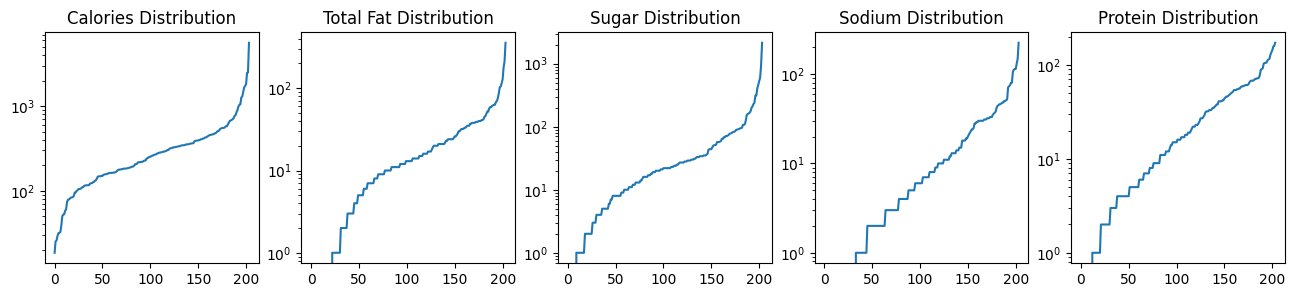

50% of calories data lies between 152.75 and 402.43
50% of total fat data lies between 5.00 and 27.25
50% of sugar data lies between 8.00 and 50.25
50% of sodium data lies between 2.00 and 22.25
50% of protein data lies between 4.75 and 46.00


In [126]:
d_range = (25, 75)

f, axs = plt.subplots(1,5,figsize=(16,3))

axs[0].plot(sorted(nutrVal['calories']))
axs[0].set_yscale('log')
axs[0].set_title('Calories Distribution')

axs[1].plot(sorted(nutrVal['totalFat']))
axs[1].set_yscale('log')
axs[1].set_title('Total Fat Distribution')

axs[2].plot(sorted(nutrVal['sugar']))
axs[2].set_yscale('log')
axs[2].set_title('Sugar Distribution')

axs[3].plot(sorted(nutrVal['sodium']))
axs[3].set_yscale('log')
axs[3].set_title('Sodium Distribution')

axs[4].plot(sorted(nutrVal['protein']))
axs[4].set_yscale('log')
axs[4].set_title('Protein Distribution')

plt.show()

calories_range = (
      np.percentile(nutrVal['calories'], d_range[0]), 
      np.percentile(nutrVal['calories'], d_range[1]))
print(f"{d_range[1]-d_range[0]}% of calories data lies between " +
      f"{calories_range[0]:.2f} and {calories_range[1]:.2f}")

fat_range = (
      np.percentile(nutrVal['totalFat'], d_range[0]), 
      np.percentile(nutrVal['totalFat'], d_range[1]))
print(f"{d_range[1]-d_range[0]}% of total fat data lies between " +
      f"{fat_range[0]:.2f} and {fat_range[1]:.2f}")

sugar_range = (
      np.percentile(nutrVal['sugar'], d_range[0]), 
      np.percentile(nutrVal['sugar'], d_range[1]))
print(f"{d_range[1]-d_range[0]}% of sugar data lies between " +
      f"{sugar_range[0]:.2f} and {sugar_range[1]:.2f}")

sodium_range = (
      np.percentile(nutrVal['sodium'], d_range[0]), 
      np.percentile(nutrVal['sodium'], d_range[1]))
print(f"{d_range[1]-d_range[0]}% of sodium data lies between " +
      f"{sodium_range[0]:.2f} and {sodium_range[1]:.2f}")

protein_range = (
      np.percentile(nutrVal['protein'], d_range[0]), 
      np.percentile(nutrVal['protein'], d_range[1]))
print(f"{d_range[1]-d_range[0]}% of protein data lies between " +
      f"{protein_range[0]:.2f} and {protein_range[1]:.2f}")

In [128]:
start_time = time.time()

# Suggest 'fit' recipe
nutrValRec = gds.run_cypher('''
    MATCH (r:Recipe)
    WHERE NOT r.id IN $reviewedRecipes
    WITH r, apoc.convert.fromJsonList(r.nutrition) AS nutritionList
    WHERE   nutritionList[0] > $min_0 AND nutritionList[0] < $max_0    // CALORIES
        AND nutritionList[1] > $min_1 AND nutritionList[1] < $max_1    // TOTAL FAT (PDV)
        AND nutritionList[2] > $min_1 AND nutritionList[2] < $max_2    // SUGAR (PVD)
        AND nutritionList[3] > $min_3 AND nutritionList[3] < $max_3    // SODIUM (PDV)
        AND nutritionList[4] > $min_4 AND nutritionList[4] < $max_4    // PROTEIN
    RETURN r.id as RecipeID, r.name AS RecipeName, nutritionList
    LIMIT $limit
    ''', params={
        'limit': n_sugestions, 
        'reviewedRecipes': reviewed_recipes,
        'min_0': calories_range[0], 'max_0': calories_range[1],
        'min_1': fat_range[0], 'max_1': fat_range[1],
        'min_2': sugar_range[0], 'max_2': sugar_range[1],
        'min_3': sodium_range[0], 'max_3': sodium_range[1],
        'min_4': protein_range[0], 'max_4': protein_range[1]})

end_time = time.time()

# Print execution time
print(f'\nQuery executed in {end_time-start_time:.2f} seconds')

# Show result
nutrValRec


Query executed in 0.01 seconds


,RecipeID,RecipeName,nutritionList
0,54100,grilled venison burgers,"[190.9, 10.0, 10.0, 10.0, 45.0, 15.0, 2.0]"
1,93958,i yam what i yam muffins,"[171.8, 9.0, 28.0, 10.0, 8.0, 4.0, 8.0]"
2,33606,italian sandwich pasta salad,"[279.2, 14.0, 12.0, 22.0, 23.0, 11.0, 12.0]"
3,35653,make it your way shortcakes,"[175.2, 11.0, 15.0, 8.0, 7.0, 21.0, 7.0]"
4,32169,make that chicken dance salsa pasta,"[255.2, 18.0, 39.0, 18.0, 39.0, 13.0, 6.0]"


We can also combine the user preferences on ingredients with those on nutritional values to provide even more accurate recommendations. We can than sort the result based on most matching favorites ingredients and show first recipes with less preparation time.

In [134]:
start_time = time.time()

# Suggest 'fit' recipe
fitRecFavIngr = gds.run_cypher('''
    MATCH (r:Recipe)-[:WITH_INGREDIENTS]->(i:Ingredient)
    WHERE NOT r.id IN $reviewedRecipes
    WITH r, COLLECT(i.name) AS recipeIngredients, apoc.convert.fromJsonList(r.nutrition) AS nutritionList
    WHERE 
        ANY(ingredient IN recipeIngredients WHERE ingredient IN $favIngreds) 
        AND nutritionList[0] > $min_0 AND nutritionList[0] < $max_0    // CALORIES
        AND nutritionList[1] > $min_1 AND nutritionList[1] < $max_1    // TOTAL FAT (PDV)
        AND nutritionList[2] > $min_1 AND nutritionList[2] < $max_2    // SUGAR (PVD)
        AND nutritionList[3] > $min_3 AND nutritionList[3] < $max_3    // SODIUM (PDV)
        AND nutritionList[4] > $min_4 AND nutritionList[4] < $max_4    // PROTEIN
    RETURN r.id as RecipeID, r.name AS RecipeName, recipeIngredients, SIZE([ingredient IN recipeIngredients WHERE ingredient IN $favIngreds]) AS matchCount, nutritionList, r.minutes as prepTime
    ORDER BY matchCount DESC, toInteger(prepTime)
    LIMIT $limit
    ''', params={
        'limit': n_sugestions, 
        'reviewedRecipes': reviewed_recipes,
        'favIngreds': favorite_ingredients,
        'excluded_ingr': excluded_ingr,
        'min_0': calories_range[0], 'max_0': calories_range[1],
        'min_1': fat_range[0], 'max_1': fat_range[1],
        'min_2': sugar_range[0], 'max_2': sugar_range[1],
        'min_3': sodium_range[0], 'max_3': sodium_range[1],
        'min_4': protein_range[0], 'max_4': protein_range[1]})

end_time = time.time()

# Print execution time
print(f'\nQuery executed in {end_time-start_time:.2f} seconds')

# Show result
fitRecFavIngr


Query executed in 10.68 seconds


,RecipeID,RecipeName,recipeIngredients,matchCount,nutritionList,prepTime
0,192089,pasta with tasty broccoli sauce,"[garlic cloves, pasta, salt and pepper, broccoli, lemon juice, onion, parmesan cheese, olive oil, chicken broth]",5,"[342.3, 15.0, 19.0, 12.0, 28.0, 11.0, 16.0]",20
1,312651,lemon pasta with sour cream,"[parmesan cheese, spaghettini, lemon pepper seasoning, butter, lemon juice, onion, sour cream, salt, parsley, lemon, zest of, garlic cloves, milk]",5,"[280.3, 21.0, 11.0, 5.0, 15.0, 40.0, 10.0]",20
2,161388,fish cushions with papaya raisin dip,"[papaya, olive oil, red chili pepper, egg white, fish fillets, lemon juice, egg yolk, salt and pepper, brown sugar, coriander, coconut flakes, sour cream, rum, raisins, garlic clove, milk, bread]",5,"[293.4, 9.0, 44.0, 16.0, 35.0, 9.0, 13.0]",40
3,484785,creamy artichoke spinach crab dip,"[hot sauce, italian cheese blend, sour cream, onion, parmesan cheese, lump crabmeat, tomatoes, frozen chopped spinach, lemon juice, mayonnaise, olive oil, worcestershire sauce, pepper, salt, garlic cloves, cream cheese, artichoke hearts]",5,"[187.4, 21.0, 11.0, 8.0, 17.0, 33.0, 2.0]",55
4,152724,sizzling vegetable fajitas tgif copycat,"[guacamole, salt, lemon juice, fresh cilantro, salsa, pico de gallo, jalapeno pepper, cheddar cheese, onion, margarine, flour tortilla, garlic cloves, lemon, juice of, pepper, sour cream, diced tomato, parmesan cheese, carrots, olive oil, lime wedge, cilantro, broccoli]",5,"[188.5, 25.0, 11.0, 14.0, 7.0, 16.0, 2.0]",60


### Recommendation based on website tags